<a href="https://colab.research.google.com/github/CompoundEmotion-Recognition/SCNN_Hybrid_model/blob/main/HybridSCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INSTALL LIBRARIES

In [1]:
pip install tensorflow --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.5 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Succes

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The height of the image is:  100
The width of the image is:  100


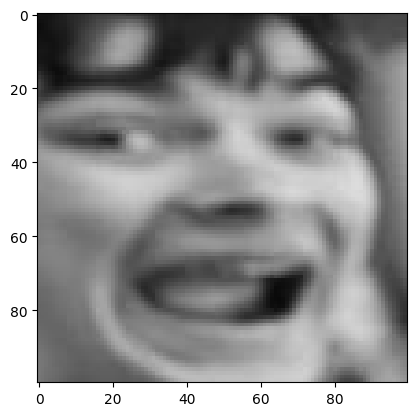

In [4]:

# import required module
from PIL import Image

# get image
filepath = "/content/drive/MyDrive/dataset/test/1/test_470_aligned.jpg"
img = Image.open(filepath)

# get width and height
width = img.width
height = img.height

# display width and height
print("The height of the image is: ", height)
print("The width of the image is: ", width)

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread("/content/drive/MyDrive/dataset/test/1/test_470_aligned.jpg")
imgplot = plt.imshow(img)
plt.show()

IMPORTING LIBRARIES

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import callbacks,optimizers
import keras

DEFINING THE TRAIN AND TEST IMAGES

In [6]:
train = ImageDataGenerator(rescale=1/255)
validation = ImageDataGenerator(rescale= 1./255)

In [7]:
train_dataset = train.flow_from_directory('/content/drive/MyDrive/dataset/train',
                                          target_size=(200,200),
                                          batch_size=32,
                                          class_mode='categorical')

validation_dataset = validation.flow_from_directory('/content/drive/MyDrive/dataset/test',
                                          target_size=(200,200),
                                          batch_size=32,
                                          class_mode='categorical')

Found 3164 images belonging to 11 classes.
Found 725 images belonging to 11 classes.


INITIALIZING THE HOG 1D FEATURES

In [4]:
df = pd.read_csv('/content/drive/MyDrive/anjHOG.csv', header=None)
df.head()

,0
0,0.035639
1,0.111797
2,0.255989
3,0.060508
4,0.072334


DIFINING THE MODEL

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 99, 99, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 48, 48, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 46, 46, 64)        18496 

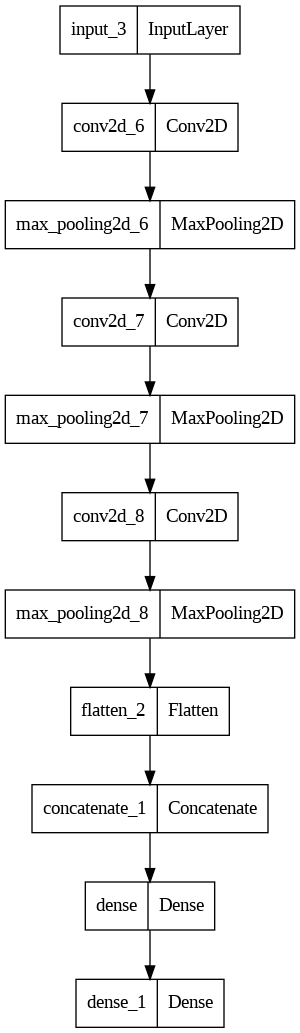

In [5]:
from tensorflow.keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D

visible = Input(shape=(200,200,3))
conv1 = Conv2D(16,(3,3), input_shape=(200,200,3), activation='relu')(visible)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(32,(3,3), activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(64,(3,3), activation='relu')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
flat = Flatten()(pool3)
concat_ = keras.layers.Concatenate()([flat, df])
hidden1 = Dense(512, activation='relu')(concat_)
output = Dense(11, activation='softmax')(hidden1)
model = Model(inputs=visible, outputs=output)
# summarize layers
print(model.summary())
# plot graph
plot_model(model, to_file='convolutional_neural_network.png')

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
import keras.backend as K
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives+K.epsilon())
        return recall


    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(loss= 'categorical_crossentropy',
              optimizer = RMSprop(learning_rate=0.001),
              metrics=['Precision','accuracy','Recall','AUC',f1_score])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(train_dataset )
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(train_dataset.classes, y_pred))
print('Classification Report')
target_names = ['0', '1','2','3','4','5','6','7','8','9','10']
print(classification_report(train_dataset.classes, y_pred, target_names=target_names))

99/99 [==============================] - 921s 9s/step
Confusion Matrix
[[  1 478   0  71   2   0   0   0   0   0   0]
 [  0 576   0  92   0   0   0   0   0   0   0]
 [  1  97   0  16   0   0   0   0   0   0   0]
 [  2 186   0  29   0   0   0   0   0   0   0]
 [  0  90   0  16   0   0   0   0   0   0   0]
 [  0 119   0  18   0   0   0   0   0   0   0]
 [  1  61   0   7   0   0   0   0   0   0   0]
 [  1 517   0  88   0   0   0   0   0   0   0]
 [  0 101   0  16   0   0   0   0   0   0   0]
 [  3 371   0  66   0   0   0   0   0   0   0]
 [  0 119   0  19   0   0   0   0   0   0   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.11      0.00      0.00       552
           1       0.21      0.86      0.34       668
           2       0.00      0.00      0.00       114
           3       0.07      0.13      0.09       217
           4       0.00      0.00      0.00       106
           5       0.00      0.00      0.00       137
          

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
h = model.fit(train_dataset, epochs=20, validation_data=validation_dataset)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


99/99 ━━━━━━━━━━━━━━━━━━━━ 1314s 13s/step - AUC: 0.6812 - Precision: 0.1612 - Recall: 0.0152 - accuracy: 0.1953 - f1_score: 0.0177 - loss: 3.0999 - val_AUC: 0.7319 - val_Precision: 0.5442 - val_Recall: 0.1103 - val_accuracy: 0.2869 - val_f1_score: 0.1810 - val_loss: 2.1551
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - AUC: 0.8000 - Precision: 0.5605 - Recall: 0.0818 - accuracy: 0.3584 - f1_score: 0.1319 - loss: 1.8852 - val_AUC: 0.8247 - val_Precision: 0.6949 - val_Recall: 0.0566 - val_accuracy: 0.4138 - val_f1_score: 0.1012 - val_loss: 1.8127
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - AUC: 0.8770 - Precision: 0.6885 - Recall: 0.2455 - accuracy: 0.4905 - f1_score: 0.3505 - loss: 1.5270 - val_AUC: 0.8484 - val_Precision: 0.7348 - val_Recall: 0.1338 - val_accuracy: 0.4469 - val_f1_score: 0.2256 - val_loss: 1.6862
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - AUC: 0.9178 - Precision: 0.7551 - Recall: 0.3830 - accuracy: 0.5631 - f1_score: 0.5046 - loss: 1.2639 - val

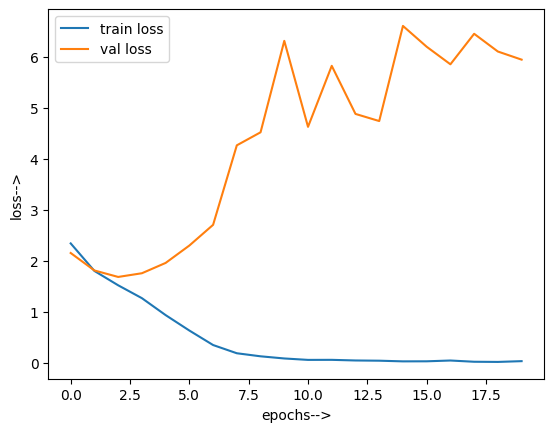

In [14]:
import matplotlib.pyplot as plt
plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('LossVal_loss')
plt.xlabel('epochs-->')
plt.ylabel('loss-->')
plt.show()

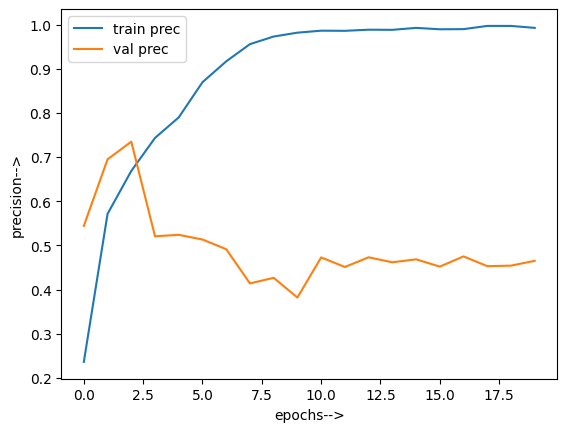

<Figure size 640x480 with 0 Axes>

In [17]:
#plot the precision
plt.plot(h.history['Precision'], label='train prec')
plt.plot(h.history['val_Precision'], label='val prec')
plt.legend()
plt.xlabel('epochs-->')
plt.ylabel('precision-->')
plt.show()
plt.savefig('AccVal_prec')

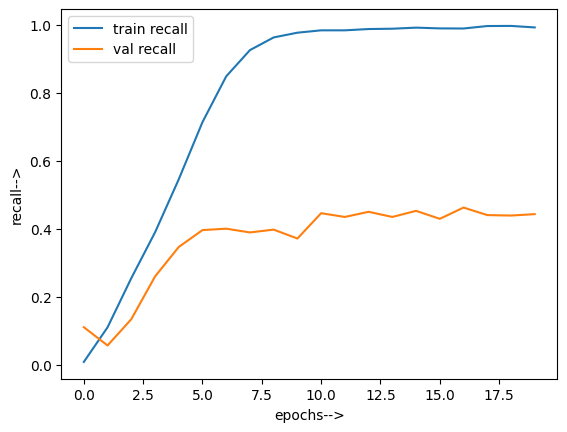

<Figure size 640x480 with 0 Axes>

In [19]:
#plot recall
plt.plot(h.history['Recall'], label='train recall')
plt.plot(h.history['val_Recall'], label='val recall')
plt.legend()
plt.xlabel('epochs-->')
plt.ylabel('recall-->')
plt.show()
plt.savefig('AccVal_rec')

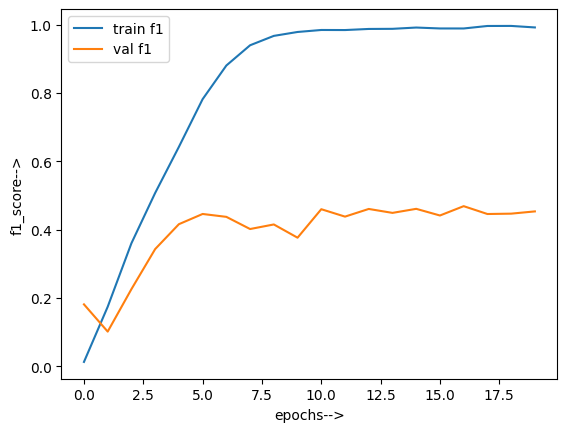

<Figure size 640x480 with 0 Axes>

In [20]:

#plot f1_score
plt.plot(h.history['f1_score'], label='train f1')
plt.plot(h.history['val_f1_score'], label='val f1')
plt.legend()
plt.xlabel('epochs-->')
plt.ylabel('f1_score-->')
plt.show()
plt.savefig('AccVal_f1')

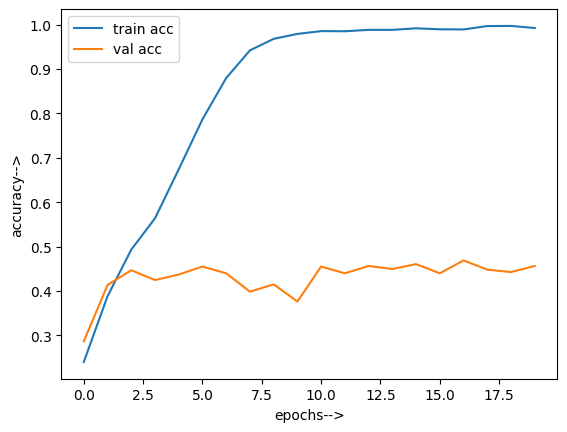

<Figure size 640x480 with 0 Axes>

In [21]:
# plot the accuracy
plt.plot(h.history['accuracy'], label='train acc')
plt.plot(h.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel('epochs-->')
plt.ylabel('accuracy-->')
plt.show()
plt.savefig('AccVal_acc')

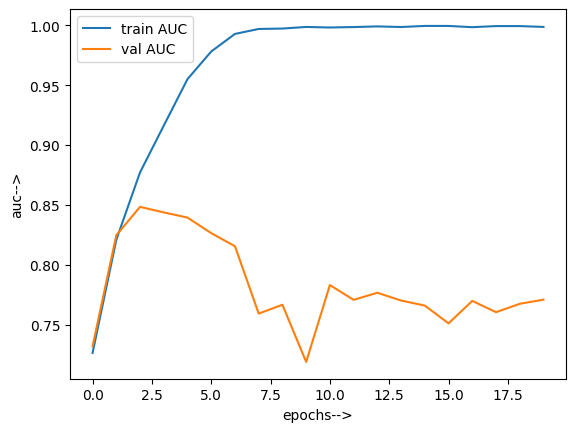

<Figure size 640x480 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt
plt.plot(h.history['AUC'], label='train AUC')
plt.plot(h.history['val_AUC'], label='val AUC')
plt.legend()
plt.xlabel('epochs-->')
plt.ylabel('auc-->')
plt.show()
plt.savefig('AUCVal_AUC')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
val [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
sadly disgusted 6


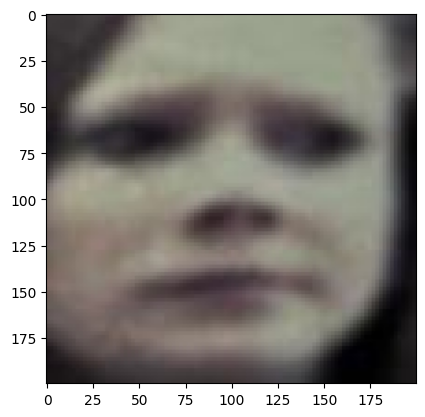

In [24]:
img=image.load_img('/content/drive/MyDrive/dataset/test/6/test_005_aligned.jpg',target_size=(200,200))
plt.imshow(img)
X=image.img_to_array(img)
X=np.expand_dims(X,axis=0)
images=np.vstack([X])
val=model.predict(images)
print("val %s"%val)
rach=val.argmax()
if rach==0:
  print("happily surprised 1")

if rach==1:
  print("angrily disgusted 10")

if rach==2:
  print("disgustedly surprised 11")

if rach==3:
  print("happily disgusted 2")

if rach==4:
  print("sadly fearful 3")

if rach==5:
  print("sadly angry 4")

if rach==6:
  print("sadly surprised 5")

if rach==7:
  print("sadly disgusted 6")

if rach==8:
  print("fearfully angry 7")

if rach==9:
  print("fearfully surprised 8")

if rach==10:
  print("angrily surprised 9")


In [ ]:

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      //await new Promise((resolve) => capture.onclick = resolve);
      capture.onclick
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename



In [ ]:
import time
counter_time = 0
while True:
   time.sleep(8)
   counter_time = counter_time + 1
   if counter_time== 3 or 23 :
    from IPython.display import Image
    try:
       filename = take_photo()
       print('Saved to {}'.format(filename))
       display(Image(filename))
    except Exception as err:
       print(str(err))
   if counter_time== 6 or 26 :
       img=image.load_img('/content/photo.jpg',target_size=(200,200))
       plt.imshow(img)
       X=image.img_to_array(img)
       X=np.expand_dims(X,axis=0)
       images=np.vstack([X])
       val=model.predict(images)
       print("val %s"%val)
       rach=val.argmax()
       if rach==0:
         print("Happily Surprised")
       if rach==1:
         print("Happily Disgusted")
       if rach==2:
         print(" Sadly Fearful")
       if rach==3:
         print("Sadly Angry")
       if rach==4:
         print(" Sadly Surprised")
       if rach==5:
         print("Sadly Disgusted")
       if rach==6:
         print(" Fearfully Angry")
       if rach==7:
         print("Fearfully Surprised")
       if rach==8:
         print("Angrily Surprised")
       if rach==9:
         print("Angrily Disgusted")
       if rach==10:
         print("Disgustedly Surprised")


